In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import pickle

from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
"""
PARAMETERS
"""

lr = 1e-5
dpath = '/kaggle/input/cifar10-python/cifar-10-batches-py'

splits = {
    'train': [f'{dpath}/data_batch_{i}' for i in range(1,5)],
    'val'  : [f'{dpath}/data_batch_5']
}

DEBUG = False
debug_len = {
    'train': 128,
    'val': 32
}

In [3]:
class Cifar10Dataset(Dataset):
    
    def __init__(self, batch_files):
        
        image_batches = []
        label_batches = []
        
        for batch_file in batch_files:
            with open(batch_file, 'rb') as f:
                batch = pickle.load(f, encoding='bytes')
                image_batches.append(batch[b'data'])
                label_batches.append(batch[b'labels'])
        
        self.images = torch.tensor(np.vstack(image_batches)).float()
        self.labels = torch.tensor(np.hstack(label_batches)).long()
        
        # image transformations
        mean = self.images.mean(axis=0)
        stdev = self.images.std(axis=0)
        
        self.images = (self.images - mean)/stdev
        
        self.images = self.images.reshape((self.images.shape[0],3,32,32))
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (self.images[idx], self.labels[idx])

In [4]:
class ResNetBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, downsample=False, in_dim=32*32):
        # TODO add ReLU, BatchNorm etc
        super().__init__()
        
        self.downsample = downsample
        
        self.relu = nn.ReLU()
        
        if self.downsample:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels)
            )
            self.downsampler = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=2),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        
        if self.downsample:
            return self.relu(self.downsampler(x) + self.block(x))

        return self.relu(x + self.block(x))

class ResNet(nn.Module):
    
    def __init__(self, n, r):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3,16,3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Sequential(*[ResNetBlock(16,16) for i in range(n)]),
            ResNetBlock(16,32,downsample=True,in_dim=32*32),
            nn.Sequential(*[ResNetBlock(32,32) for i in range(n-1)]),
            ResNetBlock(32,64,downsample=True,in_dim=16*16),
            nn.Sequential(*[ResNetBlock(64,64) for i in range(n-1)]),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,r)
        )
    
    def forward(self, x):
        return self.network(x)

## Setup

In [5]:
datasets = {split: Cifar10Dataset(batch_files) for split, batch_files in splits.items()}

In [6]:
if DEBUG:
    datasets = {split: Subset(dataset, np.arange(debug_len[split])) for split, dataset in datasets.items()}

In [7]:
dataloaders = {split: DataLoader(dataset, batch_size=128, num_workers=2, shuffle=True) for split, dataset in datasets.items()}

In [8]:
model = ResNet(2, 10)

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [10]:
train_losses = []
val_losses = []
for i in tqdm(range(100)):
    
    curr_train_loss = 0
    curr_val_loss = 0
    
    model.train()
    # training
    for images, labels in dataloaders['train']:
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        curr_train_loss += loss.detach().item()

    
    model.eval()
    with torch.no_grad():
        # validation
        for images, labels in dataloaders['val']:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            curr_val_loss += loss.detach().item()
        
    curr_train_loss /= len(datasets['train'])
    curr_val_loss /= len(datasets['val'])
    
    train_losses.append(curr_train_loss)
    val_losses.append(curr_val_loss)
    
    if (i%5 == 0):
        print(f"Epoch {i}:")
        print(f"    Train loss : {curr_train_loss}")
        print(f"    Val loss   : {curr_val_loss}")

  1%|          | 1/100 [01:42<2:49:44, 102.87s/it]

Epoch 0:
    Train loss : 9.504398501586914
    Val loss   : 5.77405901260376


  6%|▌         | 6/100 [10:22<2:42:48, 103.92s/it]

Epoch 5:
    Train loss : 11.258477173614502
    Val loss   : 16.439736196899414


 11%|█         | 11/100 [19:03<2:34:36, 104.23s/it]

Epoch 10:
    Train loss : 8.295336418914795
    Val loss   : 8.76015319519043


 16%|█▌        | 16/100 [27:46<2:26:17, 104.50s/it]

Epoch 15:
    Train loss : 11.882509407043457
    Val loss   : 11.167530472564698


 21%|██        | 21/100 [36:25<2:16:34, 103.73s/it]

Epoch 20:
    Train loss : 11.182289018249511
    Val loss   : 10.8218157913208


 26%|██▌       | 26/100 [45:01<2:07:20, 103.25s/it]

Epoch 25:
    Train loss : 11.914834887695312
    Val loss   : 16.680268853759767


 31%|███       | 31/100 [53:35<1:58:20, 102.90s/it]

Epoch 30:
    Train loss : 10.908346574401856
    Val loss   : 11.921270120239258


 36%|███▌      | 36/100 [1:02:05<1:48:58, 102.17s/it]

Epoch 35:
    Train loss : 8.77660292892456
    Val loss   : 3.89452693939209


 41%|████      | 41/100 [1:10:41<1:41:18, 103.02s/it]

Epoch 40:
    Train loss : 11.319680911254883
    Val loss   : 20.098130291748046


 46%|████▌     | 46/100 [1:19:19<1:33:12, 103.56s/it]

Epoch 45:
    Train loss : 12.601937065124512
    Val loss   : 12.91854533996582


 51%|█████     | 51/100 [1:27:57<1:24:42, 103.73s/it]

Epoch 50:
    Train loss : 10.944872436523438
    Val loss   : 9.012488445281983


 56%|█████▌    | 56/100 [1:36:37<1:16:12, 103.93s/it]

Epoch 55:
    Train loss : 12.708818811035156
    Val loss   : 9.96722561340332


 61%|██████    | 61/100 [1:45:14<1:07:13, 103.43s/it]

Epoch 60:
    Train loss : 10.602557249450683
    Val loss   : 7.871742961883545


 66%|██████▌   | 66/100 [1:53:50<58:34, 103.38s/it]  

Epoch 65:
    Train loss : 11.224377488708496
    Val loss   : 12.715613660430908


 71%|███████   | 71/100 [2:02:26<49:56, 103.33s/it]

Epoch 70:
    Train loss : 11.62119489440918
    Val loss   : 8.431861456298828


 76%|███████▌  | 76/100 [2:11:00<41:09, 102.91s/it]

Epoch 75:
    Train loss : 11.304061478424073
    Val loss   : 11.947102238464355


 81%|████████  | 81/100 [2:19:38<32:50, 103.70s/it]

Epoch 80:
    Train loss : 8.779467740631103
    Val loss   : 8.332657278442383


 86%|████████▌ | 86/100 [2:28:16<24:10, 103.64s/it]

Epoch 85:
    Train loss : 11.465520629119872
    Val loss   : 9.873566395568847


 91%|█████████ | 91/100 [2:36:57<15:36, 104.06s/it]

Epoch 90:
    Train loss : 11.460832919311523
    Val loss   : 17.80714090576172


 96%|█████████▌| 96/100 [2:45:36<06:54, 103.62s/it]

Epoch 95:
    Train loss : 8.238671006011963
    Val loss   : 10.77266287689209


100%|██████████| 100/100 [2:52:30<00:00, 103.51s/it]


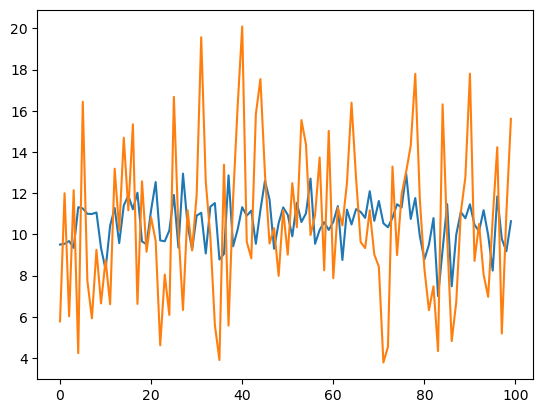

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)